Question 2.2


In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR


# 1. Charger la feuille Data avec la ligne d’en-tête correcte

df_raw = pd.read_excel("data/ie_data.xls", sheet_name="Data", header=None)

# Trouver la ligne contenant "Date" en première colonne
header_row = df_raw.index[df_raw.iloc[:,0] == "Date"][0]

# Relire la feuille avec cette ligne comme header
df = pd.read_excel("data/ie_data.xls", sheet_name="Data", header=header_row)


# 2. Extraire P, D, E
# Comme dans ton fichier : Col 1 = P, col 2 = D, col 3 = E

data = df.iloc[:, 1:4].copy()
data.columns = ["P", "D", "E"]

# Conversion en numérique (sinon le log échoue)
data = data.apply(pd.to_numeric, errors="coerce").dropna()


# 3. Transformation en logs

log_data = np.log(data)


# 4. Sélection du nombre de décalages avec le BIC

model = VAR(log_data)

lag_selection = model.select_order(maxlags=12)  
print(lag_selection.summary())

p_bic = lag_selection.bic
print("Ordre VAR sélectionné par le BIC :", p_bic)


# 5. Estimation du VAR(p_bic)

results = model.fit(p_bic)
print(results.test_causality('D', ['P']).summary())
print(results.test_causality('E', ['P']).summary())

print(results.test_causality('P', ['E']).summary())
print(results.test_causality('D', ['E']).summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -4.116      -4.107     0.01632      -4.112
1       -22.39      -22.35   1.888e-10      -22.38
2       -24.69      -24.63   1.890e-11      -24.67
3       -24.72      -24.63   1.842e-11      -24.68
4       -24.72      -24.60   1.836e-11      -24.68
5       -24.78     -24.63*   1.737e-11      -24.72
6       -24.79      -24.61   1.718e-11      -24.72
7       -24.79      -24.59   1.710e-11      -24.72
8       -24.83      -24.60   1.651e-11     -24.74*
9       -24.83      -24.58   1.647e-11      -24.74
10      -24.83      -24.55   1.642e-11      -24.73
11     -24.84*      -24.53  1.636e-11*      -24.72
12      -24.83      -24.50   1.639e-11      -24.71
--------------------------------------------------
Ordre VAR sélectionné par le BIC : 5
Granger causality F-test. H_0: P does not Granger-cause D. Conclusion: reject H_0 at 5% signific

In [34]:
import matplotlib.pyplot as plt

# IRF lorsque les prix sont classés EN PREMIER (P, D, E)

model_first = VAR(log_data[['P', 'D', 'E']])
res_first = model_first.fit(p_bic)

# IRF sur 24 périodes
irf_first = res_first.irf(24)

# IRF lorsque les prix sont classés EN DERNIER (D, E, P)

log_reordered = log_data[['D', 'E', 'P']]

model_last = VAR(log_reordered)
res_last = model_last.fit(p_bic)

irf_last = res_last.irf(24)




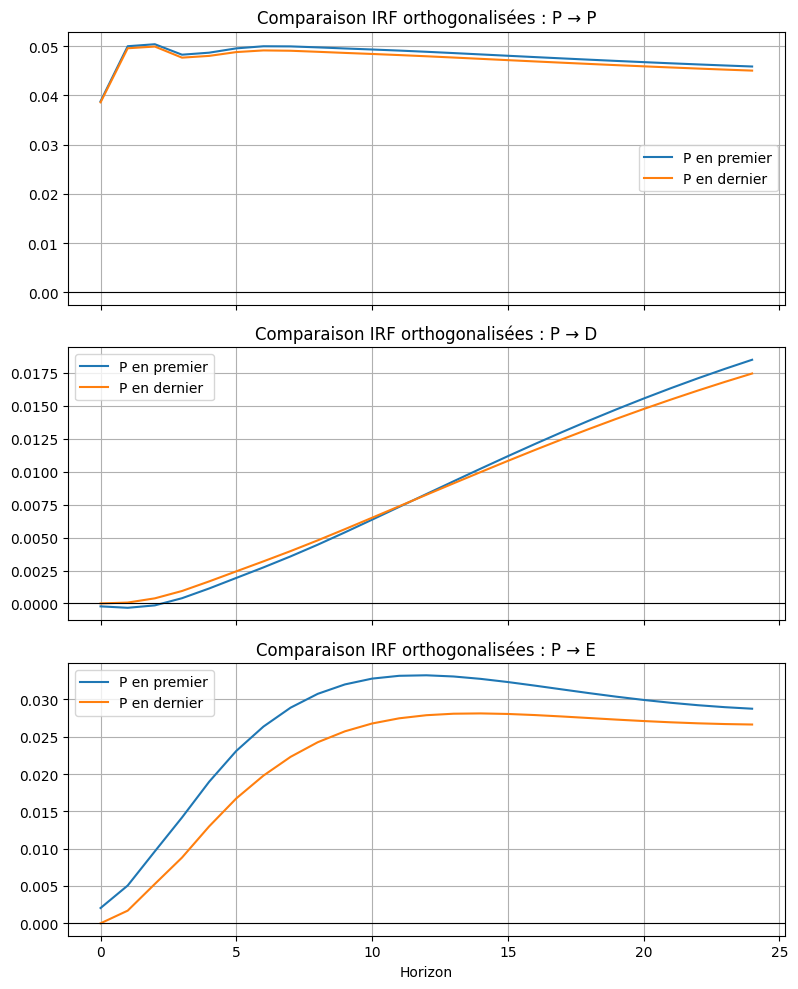

In [35]:
import matplotlib.pyplot as plt

# IRF sur 24 périodes
irf_first = res_first.irf(24)   # VAR avec ordre [P, D, E]
irf_last  = res_last.irf(24)    # VAR avec ordre [D, E, P]

# On utilise des chocs indépendants
irf1 = irf_first.orth_irfs
irf2 = irf_last.orth_irfs

h = np.arange(irf1.shape[0])

fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# 1) P → P
axes[0].plot(h, irf1[:, 0, 0], label="P en premier")
axes[0].plot(h, irf2[:, 2, 2], label="P en dernier")
axes[0].set_title("Comparaison IRF orthogonalisées : P → P")
axes[0].axhline(0, color="black", linewidth=0.8)
axes[0].legend()
axes[0].grid(True)

# 2) P → D
axes[1].plot(h, irf1[:, 1, 0], label="P en premier")
axes[1].plot(h, irf2[:, 0, 2], label="P en dernier")
axes[1].set_title("Comparaison IRF orthogonalisées : P → D")
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].legend()
axes[1].grid(True)

# 3) P → E
axes[2].plot(h, irf1[:, 2, 0], label="P en premier")
axes[2].plot(h, irf2[:, 1, 2], label="P en dernier")
axes[2].set_title("Comparaison IRF orthogonalisées : P → E")
axes[2].axhline(0, color="black", linewidth=0.8)
axes[2].legend()
axes[2].grid(True)

axes[2].set_xlabel("Horizon")
plt.tight_layout()
plt.show()


In [36]:
from statsmodels.tsa.stattools import adfuller

# Petite fonction utilitaire
def adf_test(series, name):
    result = adfuller(series, autolag="BIC")
    stat, pvalue, usedlag, nobs, crit, icbest = result
    print(f"=== Test ADF pour {name} ===")
    print(f"Statistique ADF : {stat:.3f}")
    print(f"p-value         : {pvalue:.4f}")

# 1) Tests ADF sur log(P), log(D), log(E)
adf_test(log_data["P"], "log(P)")
adf_test(log_data["D"], "log(D)")
adf_test(log_data["E"], "log(E)")

# 2) Construire log(P/D) et log(P/E)
log_PD = log_data["P"] - log_data["D"]   # log(P/D) = logP - logD
log_PE = log_data["P"] - log_data["E"]   # log(P/E) = logP - logE

# 3) Tests ADF sur log(P/D) et log(P/E)
adf_test(log_PD, "log(P/D)")
adf_test(log_PE, "log(P/E)")


=== Test ADF pour log(P) ===
Statistique ADF : 1.292
p-value         : 0.9966
=== Test ADF pour log(D) ===
Statistique ADF : 0.648
p-value         : 0.9887
=== Test ADF pour log(E) ===
Statistique ADF : 0.258
p-value         : 0.9753
=== Test ADF pour log(P/D) ===
Statistique ADF : -2.202
p-value         : 0.2056
=== Test ADF pour log(P/E) ===
Statistique ADF : -4.605
p-value         : 0.0001


In [37]:
from statsmodels.tsa.stattools import coint


# Test d’Engle–Granger pour chaque paire

def eg_test(x, y, name):
    score, pvalue, crit = coint(x, y)
    print(f"Test de cointégration Engle-Granger : {name}")
    print(f"Statistique de test : {score:.3f}")
    print(f"p-value             : {pvalue:.4f}")


# [P, D]
eg_test(log_data["P"], log_data["D"], "[P, D]")

# [P, E]
eg_test(log_data["P"], log_data["E"], "[P, E]")

# [E, D]
eg_test(log_data["E"], log_data["D"], "[E, D]")


Test de cointégration Engle-Granger : [P, D]
Statistique de test : -3.492
p-value             : 0.0331
Test de cointégration Engle-Granger : [P, E]
Statistique de test : -5.999
p-value             : 0.0000
Test de cointégration Engle-Granger : [E, D]
Statistique de test : -7.358
p-value             : 0.0000
